In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
from PIL import Image

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/train1"
transforms = tvt.Compose([tvt.ToTensor(), tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainingData = datasets.ImageFolder(root = path,transform = transforms )
trainloader = DataLoader(dataset = trainingData, num_workers = 0, batch_size = 100, shuffle = True)

In [ ]:
#Code from DL Studio
def weights_init(m):    
    classname = m.__class__.__name__     
    if classname.find('Conv') != -1:         
        nn.init.normal_(m.weight.data, 0.0, 0.02)      
    elif classname.find('BatchNorm') != -1:         
        nn.init.normal_(m.weight.data, 1.0, 0.02)       
        nn.init.constant_(m.bias.data, 0)

In [ ]:
#Code from DL Studio
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv_in = nn.Conv2d( 3, 64, kernel_size=4, stride=2, padding=1)
    self.conv_in2 = nn.Conv2d( 64, 128, kernel_size=4, stride=2, padding=1)
    self.conv_in3 = nn.Conv2d( 128, 256, kernel_size=4, stride=2, padding=1)
    self.conv_in4 = nn.Conv2d( 256, 512, kernel_size=4, stride=2, padding=1)
    self.conv_in5 = nn.Conv2d( 512, 1, kernel_size=4, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(128)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(512)
    self.sig = nn.Sigmoid()
  def forward(self, x):
    x = torch.nn.functional.leaky_relu(self.conv_in(x), negative_slope=0.2, inplace=True)
    x = self.bn1(self.conv_in2(x))
    x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
    x = self.bn2(self.conv_in3(x))
    x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
    x = self.bn3(self.conv_in4(x))
    x = torch.nn.functional.leaky_relu(x, negative_slope=0.2, inplace=True)
    x = self.conv_in5(x)
    x = self.sig(x)
    return x

In [ ]:
#Code from DL Studio
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.latent_to_image = nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0,bias=False)
    self.upsampler2 = nn.ConvTranspose2d( 512, 256, kernel_size=4, stride=2, padding=1, bias=False)
    self.upsampler3 = nn.ConvTranspose2d (256, 128, kernel_size=4, stride=2, padding=1, bias=False)
    self.upsampler4 = nn.ConvTranspose2d (128, 64, kernel_size=4, stride=2, padding=1, bias=False)
    self.upsampler5 = nn.ConvTranspose2d( 64, 3, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(64)
    self.tanh = nn.Tanh()
  def forward(self, x):
    x = self.latent_to_image(x)
    x = torch.nn.functional.relu(self.bn1(x))
    x = self.upsampler2(x)
    x = torch.nn.functional.relu(self.bn2(x))
    x = self.upsampler3(x)
    x = torch.nn.functional.relu(self.bn3(x))
    x = self.upsampler4(x)
    x = torch.nn.functional.relu(self.bn4(x))
    x = self.upsampler5(x)
    x = self.tanh(x)
    return x

In [ ]:
#Not working
def run_wgan(generator, discriminator,dataloader, learning_rate = 2e-4, epochs = 20, device = 'cuda',batch_size = 200):

  nz = 100
  generator = generator.to(device)
  critic = discriminator.to(device)
  generator.apply(weights_init)
  discriminator.apply(weights_init)
  noise_vector = torch.randn(batch_size, nz, 1,1).to(device)
  optim_disc = torch.optim.RMSprop(discriminator.parameters(), lr= learning_rate)
  optim_gen = torch.optim.RMSprop(generator.parameters(), lr= learning_rate)

  gen_loss = []
  disc_loss = []
  mean_D_loss = []
  mean_G_loss = []
  iters = 0
  critic_iterations = 5
  weight_clip = 0.01
  for epoch in range(epochs):

    g_losses_per_cycle = []
    d_losses_per_cycle = []
    # Discriminator Training
    for i, data in enumerate(dataloader):

      real_image = data[0].to(device)

      for iter in range(critic_iterations):
        critic.zero_grad()

        noise = torch.randn(batch_size, nz, 1, 1, device = device)
        fakes = generator(noise)
        critic_real = critic(real_image).reshape(-1)
        critic_fake = critic(fakes).reshape(-1)
        loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
        critic.zero_grad()
        if iter == critic_iterations-1:
          loss_critic.backward()

        else:


          loss_critic.backward(retain_graph = True)
        d_losses_per_cycle.append(loss_critic)
        optim_disc.step()
        for p in critic.parameters():
          p.data.clamp_(-weight_clip, weight_clip)
        
      ##Generator
      generator.zero_grad()
      gen_out = critic(fakes).reshape(-1)
      loss_g = -torch.mean(gen_out)
      
      loss_g.backward()
      optim_gen.step()

      if (i + 1) % 50 == 0:


          
          
        disc_loss2 = torch.mean(torch.FloatTensor(d_losses_per_cycle))
        gen_loss2 = torch.mean(torch.FloatTensor(g_losses_per_cycle))
        mean_D_loss.append(disc_loss2)
        mean_G_loss.append(gen_loss2)
        print("[epoch=%d/%d iter=%4d] mean_D_loss=%7.4f mean_G_loss=%7.4f" % ((epoch+1),epochs,(i+1), disc_loss2, gen_loss2)) 

        d_losses_per_cycle = []
        g_losses_per_cycle = []
    
      disc_loss.append(loss_critic.item())
      gen_loss.append(loss_g.item())
            
    

            
            
          
  torch.save(generator, 'gen.pth')  
  torch.save(discriminator, 'dis.pth')
  return disc_loss, gen_loss

In [ ]:
def run_wgan(generator, discriminator, dataloader, learning_rate=2e-4, epochs=25, device='cuda', batch_size=100):
    nz = 100
    generator = generator.to(device)
    critic = discriminator.to(device)
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    noise_vector = torch.randn(batch_size, nz, 1, 1).to(device)
    optim_disc = torch.optim.RMSprop(discriminator.parameters(), lr=learning_rate)
    optim_gen = torch.optim.RMSprop(generator.parameters(), lr=learning_rate)

    gen_loss = []
    disc_loss = []
    mean_D_loss = []
    mean_G_loss = []
    iters = 0
    critic_iterations = 5
    weight_clip = 0.01
    for epoch in range(epochs):
        g_losses_per_cycle = []
        d_losses_per_cycle = []

        for i, data in enumerate(dataloader):
            real_image = data[0].to(device)

            # Discriminator Training
            critic.zero_grad()  # Move this line to the beginning of the discriminator training loop
            for _ in range(critic_iterations):
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
                fakes = generator(noise)
                critic_real = critic(real_image).reshape(-1)
                critic_fake = critic(fakes.detach()).reshape(-1)
                loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
                d_losses_per_cycle.append(loss_critic.item())
                loss_critic.backward()
                optim_disc.step()
                for p in critic.parameters():
                    p.data.clamp_(-weight_clip, weight_clip)

            # Generator Training
            generator.zero_grad()
            gen_out = critic(fakes).reshape(-1)
            loss_g = -torch.mean(gen_out)
            loss_g.backward()
            optim_gen.step()
            g_losses_per_cycle.append(loss_g.item())

            if (i + 1) % 50 == 0:
                disc_loss2 = torch.mean(torch.FloatTensor(d_losses_per_cycle))
                gen_loss2 = torch.mean(torch.FloatTensor(g_losses_per_cycle))
                mean_D_loss.append(disc_loss2)
                mean_G_loss.append(gen_loss2)
                print("[epoch=%d/%d iter=%4d] mean_D_loss=%7.4f mean_G_loss=%7.4f" % ((epoch + 1), epochs, (i + 1), disc_loss2, gen_loss2))

                d_losses_per_cycle = []
                g_losses_per_cycle = []

            disc_loss.append(loss_critic.item())
            gen_loss.append(loss_g.item())

    torch.save(generator, 'gen.pth')
    torch.save(discriminator, 'dis.pth')
    return disc_loss, gen_loss


In [ ]:
generator = Generator()
critic = Discriminator()

In [ ]:
train = run_wgan(generator= generator, discriminator= critic, dataloader= trainloader)

[epoch=1/25 iter=  50] mean_D_loss=-0.1930 mean_G_loss=-0.3827
[epoch=2/25 iter=  50] mean_D_loss=-0.2751 mean_G_loss=-0.3558
[epoch=3/25 iter=  50] mean_D_loss=-0.2921 mean_G_loss=-0.3489
[epoch=4/25 iter=  50] mean_D_loss=-0.2995 mean_G_loss=-0.3485
[epoch=5/25 iter=  50] mean_D_loss=-0.2928 mean_G_loss=-0.3506
[epoch=6/25 iter=  50] mean_D_loss=-0.2816 mean_G_loss=-0.3521
[epoch=7/25 iter=  50] mean_D_loss=-0.2656 mean_G_loss=-0.3570
[epoch=8/25 iter=  50] mean_D_loss=-0.2491 mean_G_loss=-0.3612
[epoch=9/25 iter=  50] mean_D_loss=-0.2493 mean_G_loss=-0.3597
[epoch=10/25 iter=  50] mean_D_loss=-0.2532 mean_G_loss=-0.3585
[epoch=11/25 iter=  50] mean_D_loss=-0.2255 mean_G_loss=-0.3683
[epoch=12/25 iter=  50] mean_D_loss=-0.1848 mean_G_loss=-0.3893
[epoch=13/25 iter=  50] mean_D_loss=-0.2103 mean_G_loss=-0.3787
[epoch=14/25 iter=  50] mean_D_loss=-0.2236 mean_G_loss=-0.3638
[epoch=15/25 iter=  50] mean_D_loss=-0.2011 mean_G_loss=-0.3724
[epoch=16/25 iter=  50] mean_D_loss=-0.1976 mean_

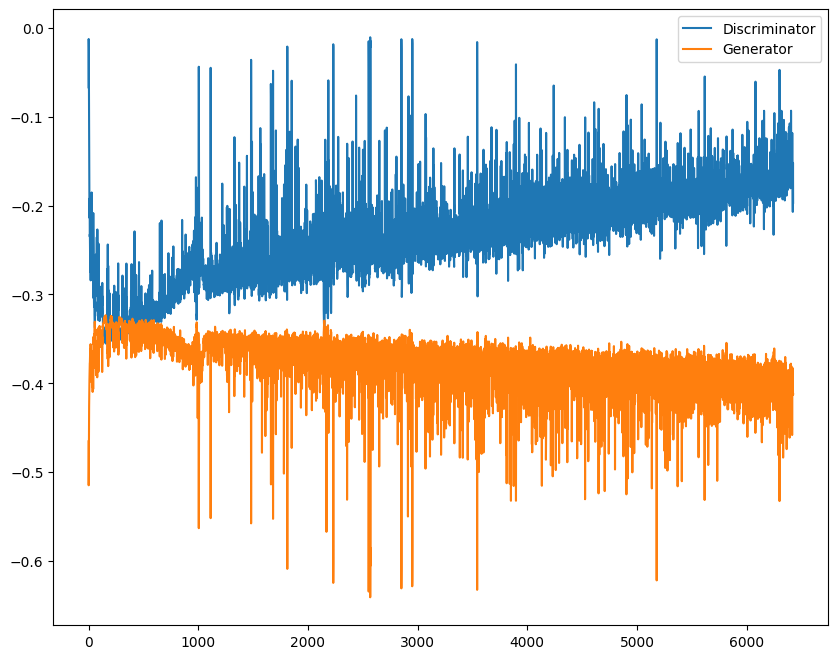

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.plot(train[0], label='Discriminator')
plt.plot(train[1], label='Generator')
plt.legend()
plt.savefig("WGAN Training Losses")
plt.show()

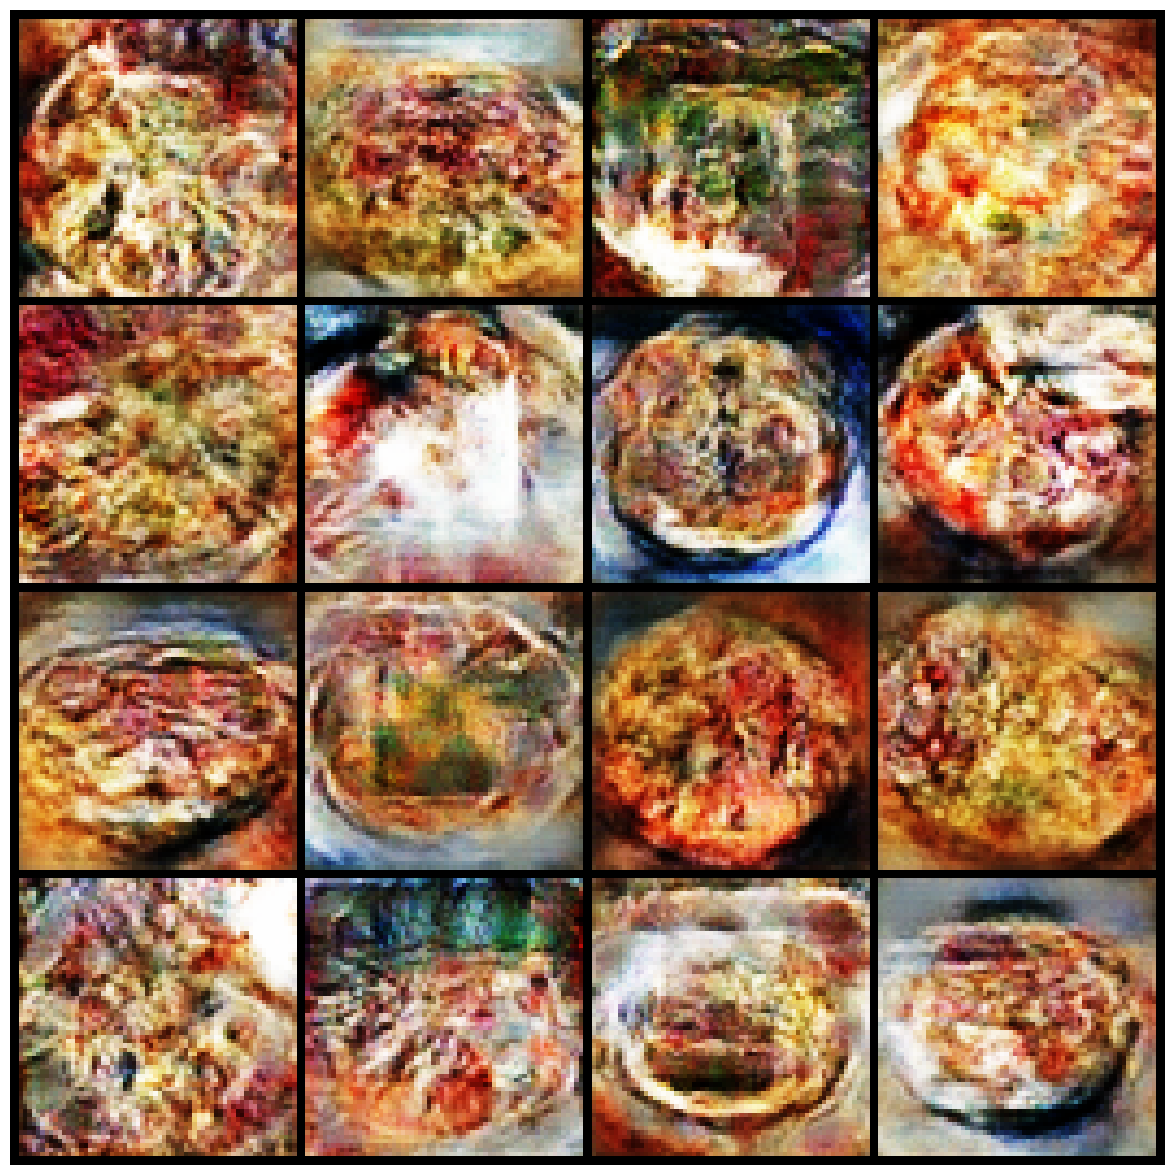

In [ ]:
import torchvision.utils as vutils
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Number of images to generate and the size of the noise vector
num_images = 16
nz = 100

# Generate random noise vectors
noise = torch.randn(num_images, nz, 1, 1).to(device)

trained_gen = torch.load('gen.pth')
generated_images = trained_gen(noise)

# Create a grid of images
grid_images = vutils.make_grid(generated_images, padding=2, normalize=True, nrow = 4)
grid_np = grid_images.cpu().numpy().transpose(1, 2, 0)
grid_image = Image.fromarray((grid_np * 255).astype('uint8'))

# Save the grid image
grid_image.save("image_grid_WGAN.png")

# Visualize the images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(np.transpose(grid_images.cpu(), (1, 2, 0)))
plt.show()

In [ ]:
# Generating fake images
device = 'cuda'
noise = torch.randn(1000, 100, 1, 1).to(device) # Generating 1000 random images

trained_gen = torch.load('gen.pth')
generated_images = trained_gen(noise)






In [ ]:
import torchvision
import os
direc_name = 'val WGAN3'
os.makedirs(direc_name)
image_paths = []


for idx, generated_images in enumerate(generated_images): 
  #print(generated_images.shape) 
  image_np = generated_images.detach().cpu().numpy().transpose(1,2,0)
  image_np = (image_np + 1) / 2  # Normalize to the range [0, 1]
  image_pil = Image.fromarray((image_np * 255).astype('uint8'))
  image_path = direc_name + '/' + str(idx) + '.png'
  #print(image_path)
  image_pil.save(image_path)
  image_paths.append(str(image_path))




  
  
  

In [ ]:
eval_paths = []
directory = '/content/drive/MyDrive/Colab Notebooks/eval'
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  # checking if it is a file
  if os.path.isfile(f):
    eval_paths.append(f)

In [ ]:
image_paths

['val WGAN3/0.png',
 'val WGAN3/1.png',
 'val WGAN3/2.png',
 'val WGAN3/3.png',
 'val WGAN3/4.png',
 'val WGAN3/5.png',
 'val WGAN3/6.png',
 'val WGAN3/7.png',
 'val WGAN3/8.png',
 'val WGAN3/9.png',
 'val WGAN3/10.png',
 'val WGAN3/11.png',
 'val WGAN3/12.png',
 'val WGAN3/13.png',
 'val WGAN3/14.png',
 'val WGAN3/15.png',
 'val WGAN3/16.png',
 'val WGAN3/17.png',
 'val WGAN3/18.png',
 'val WGAN3/19.png',
 'val WGAN3/20.png',
 'val WGAN3/21.png',
 'val WGAN3/22.png',
 'val WGAN3/23.png',
 'val WGAN3/24.png',
 'val WGAN3/25.png',
 'val WGAN3/26.png',
 'val WGAN3/27.png',
 'val WGAN3/28.png',
 'val WGAN3/29.png',
 'val WGAN3/30.png',
 'val WGAN3/31.png',
 'val WGAN3/32.png',
 'val WGAN3/33.png',
 'val WGAN3/34.png',
 'val WGAN3/35.png',
 'val WGAN3/36.png',
 'val WGAN3/37.png',
 'val WGAN3/38.png',
 'val WGAN3/39.png',
 'val WGAN3/40.png',
 'val WGAN3/41.png',
 'val WGAN3/42.png',
 'val WGAN3/43.png',
 'val WGAN3/44.png',
 'val WGAN3/45.png',
 'val WGAN3/46.png',
 'val WGAN3/47.png',
 '

In [ ]:
from pytorch_fid.fid_score import calculate_activation_statistics, calculate_frechet_distance
from pytorch_fid.inception import InceptionV3

dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

# Assuming eval_paths and image_paths are lists containing the paths of your two sets of images
m1, s1 = calculate_activation_statistics(eval_paths, model, device=device)
m2, s2 = calculate_activation_statistics(image_paths, model, device=device)
fid_value = calculate_frechet_distance(m1, s1, m2, s2)
print(f'FID: {fid_value:.2f}')


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 328MB/s]
100%|██████████| 20/20 [00:01<00:00, 15.27it/s]


FID: 177.71


In [ ]:
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
